**Author:** Rajeevkumar Yadav

**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)


# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 



/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from tcs.csv
- analyze data

In [3]:
# import all stock prices 
df = pd.read_csv("../input/tcsdata.csv", index_col = 0)
!ls
#df = pd.read_csv("../input/infosysdata/INFY.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
#print('\nnumber of different stocks: ', len(list(set(df.symbol))))
#print(list(set(df.symbol))[:10])

__notebook_source__.ipynb
<class 'pandas.core.frame.DataFrame'>
Index: 2273 entries, 2009-01-02 to 2018-03-16
Data columns (total 6 columns):
Open         2266 non-null float64
High         2266 non-null float64
Low          2266 non-null float64
Close        2266 non-null float64
Adj Close    2266 non-null float64
Volume       2266 non-null float64
dtypes: float64(6)
memory usage: 124.3+ KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,240.0,254.350006,238.574997,249.149994,213.598587,3906086.0
2009-01-05,251.0,261.500000,249.000000,257.625000,220.864258,2414888.0
2009-01-06,257.5,261.000000,249.125000,253.199997,217.070663,2959496.0
2009-01-07,259.5,259.899994,232.300003,252.399994,216.384842,4506914.0
2009-01-09,252.5,274.899994,242.500000,268.475006,230.166092,7109990.0


In [ ]:
df.tail()

In [ ]:
df.describe()

In [ ]:
df.info()

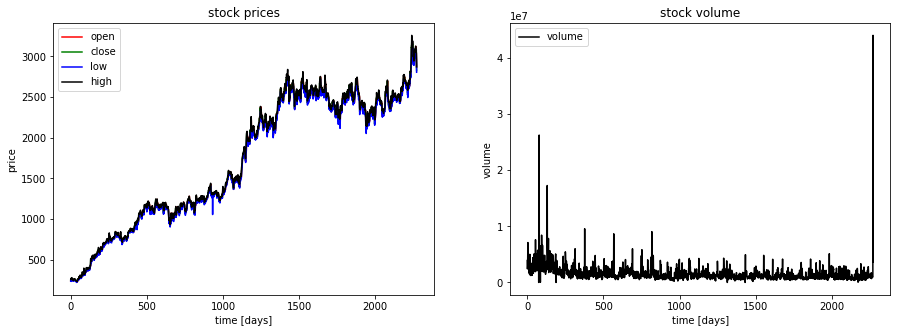

In [4]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.Low.values, color='blue', label='low')
plt.plot(df.High.values, color='black', label='high')
plt.title('stock prices')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [5]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df.copy()
#print(df_stock.columns)
#print(df_stock)
df_stock.drop(['Adj Close'],1,inplace=True)
df_stock.drop(['Volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock_norm.columns.values = ', cols)

# normalize stock
#my_df = pd.DataFrame(data=[4,5,6,7], index=range(0,4), columns=['A'])
#df_stock_norm = df_stock.copy()
#print(df_stock.isnull())
print(df_stock.head(3))
print(df_stock.dtypes)
print(np.any(np.isnan(df_stock)))
df_stock = df_stock.fillna(method='ffill')
print(np.any(np.isnan(df_stock)))

df_stock_norm = normalize_data(df_stock)



#df_stock_norm.all(np.isfinite(mat))
# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)



df_stock_norm.columns.values =  ['Open', 'High', 'Low', 'Close']
             Open        High         Low       Close
Date                                                 
2009-01-02  240.0  254.350006  238.574997  249.149994
2009-01-05  251.0  261.500000  249.000000  257.625000
2009-01-06  257.5  261.000000  249.125000  253.199997
Open     float64
High     float64
Low      float64
Close    float64
dtype: object
True
False
x_train.shape =  (1803, 19, 4)
y_train.shape =  (1803, 4)
x_valid.shape =  (225, 19, 4)
y_valid.shape =  (225, 4)
x_test.shape =  (225, 19, 4)
y_test.shape =  (225, 4)


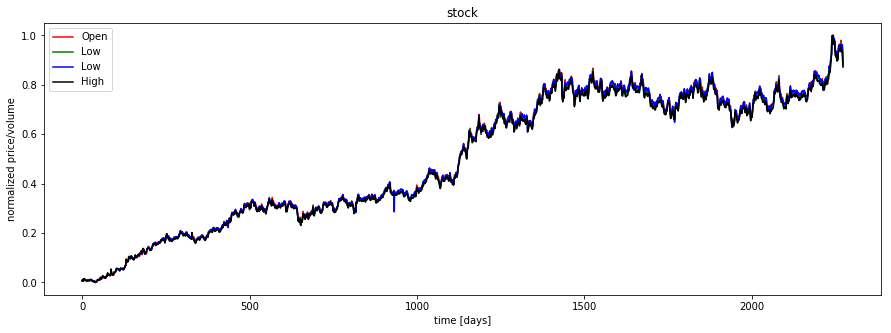

In [7]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.Open.values, color='red', label='Open')
plt.plot(df_stock_norm.Close.values, color='green', label='Low')
plt.plot(df_stock_norm.Low.values, color='blue', label='Low')
plt.plot(df_stock_norm.High.values, color='black', label='High')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [8]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

Instructions for updating:
Use the retry module or similar alternatives.
0.00 epochs: MSE train/valid = 0.058815/0.083027
4.99 epochs: MSE train/valid = 0.000190/0.000344
9.98 epochs: MSE train/valid = 0.000137/0.000238
14.98 epochs: MSE train/valid = 0.000138/0.000256
19.97 epochs: MSE train/valid = 0.000128/0.000241
24.96 epochs: MSE train/valid = 0.000108/0.000196
29.95 epochs: MSE train/valid = 0.000114/0.000209
34.94 epochs: MSE train/valid = 0.000109/0.000204
39.93 epochs: MSE train/valid = 0.000096/0.000170
44.93 epochs: MSE train/valid = 0.000095/0.000186
49.92 epochs: MSE train/valid = 0.000087/0.000163
54.91 epochs: MSE train/valid = 0.000079/0.000149
59.90 epochs: MSE train/valid = 0.000073/0.000139
64.89 epochs: MSE train/valid = 0.000158/0.000325
69.88 epochs: MSE train/valid = 0.000077/0.000141
74.88 epochs: MSE train/valid = 0.000071/0.000131
79.87 epochs: MSE train/valid = 0.000070/0.000133
84.86 epochs: MSE train/valid = 0.000060/0.000112
89.85 epochs: MSE train/valid 

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

In [10]:
y_train.shape

(1803, 4)

correct sign prediction for close - open price for train/valid/test: 0.89/0.94/0.91


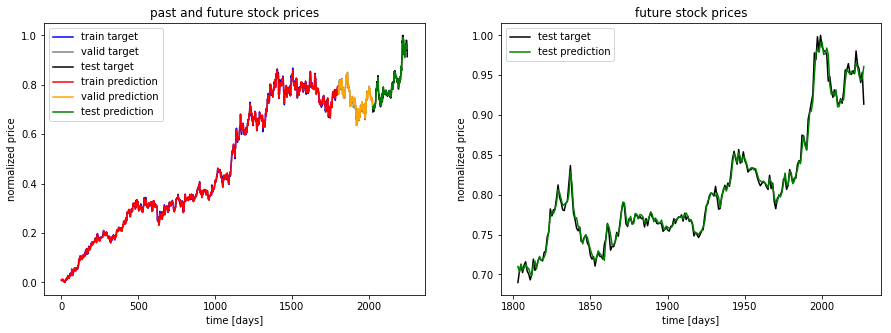

In [13]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

#y_train.to_csv(trainpred, sep=',')

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))
